## Construindo análise

### Etapa 1: Preparando o Ambiente de Trabalho

In [1]:
# Instalando as ferramentas essenciais
! pip install pandas matplotlib numpy

# Importando as bibliotecas
import pandas as pd          # Para manipular tabelas de dados
import numpy as np           # Para cálculos matemáticos
import matplotlib.pyplot as plt  # Para criar visualizações

# Configuração para melhor visualização
pd.options.display.float_format = '{:,.2f}'.format

print("✅ Ambiente preparado! Vamos começar a análise.")

✅ Ambiente preparado! Vamos começar a análise.


### Etapa 2: Carregando os Dados de Casos e População

In [ ]:
# 1) Dados de casos e óbitos
url_casos = "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv"
print("📥 Baixando dados de casos e óbitos...")
df = pd.read_csv(url_casos, parse_dates=["date"])

📥 Baixando dados de casos e óbitos...


In [6]:
# Padronizando nomes das colunas
df = df.rename(columns={
    "state": "uf",
    "newCases": "novos_casos", 
    "newDeaths": "novos_obitos"
})

In [7]:
# Removendo dados agregados nacionais
df = df[df["uf"] != "TOTAL"]

In [8]:
print(f"✅ Dados de casos carregados!")
print(f"   • {len(df):,} linhas de dados")
print(f"   • {df['uf'].nunique()-1} estados + DF")
print(f"   • Período: {df['date'].min().date()} até {df['date'].max().date()}")

✅ Dados de casos carregados!
   • 29,724 linhas de dados
   • 26 estados + DF
   • Período: 2020-02-25 até 2023-03-18


In [10]:
# 2) População por UF — Censo 2022 (SIDRA tabela 4714)
print("\n📥 Buscando população do IBGE (Censo 2022)...")
url_pop = "https://apisidra.ibge.gov.br/values/t/4714/p/2022/n3/all/v/93?formato=json"
pop = pd.read_json(url_pop)

# A primeira linha do SIDRA é metadado; removemos com iloc[1:]
pop = pop.rename(columns={"D2C": "uf_cod", "D2N": "uf_nome", "V": "populacao"}).iloc[1:]

# Garantindo tipos numéricos corretos
pop["uf_cod"] = pd.to_numeric(pop["uf_cod"], errors="coerce").astype("Int64")
pop["populacao"] = pd.to_numeric(pop["populacao"], errors="coerce").astype("Int64")

print(f"✅ População carregada: {len(pop)} UFs")


📥 Buscando população do IBGE (Censo 2022)...
✅ População carregada: 27 UFs


In [12]:
pop.head(5)

,NC,NN,MC,MN,populacao,D1C,D1N,uf_cod,uf_nome,D3C,D3N
1,3,Unidade da Federação,45,Pessoas,1581196,2022,2022,11,Rondônia,93,População residente
2,3,Unidade da Federação,45,Pessoas,830018,2022,2022,12,Acre,93,População residente
3,3,Unidade da Federação,45,Pessoas,3941613,2022,2022,13,Amazonas,93,População residente
4,3,Unidade da Federação,45,Pessoas,636707,2022,2022,14,Roraima,93,População residente
5,3,Unidade da Federação,45,Pessoas,8120131,2022,2022,15,Pará,93,População residente


In [13]:
# 3) Mapa de códigos para siglas de UF
print("\n📥 Buscando códigos e siglas das UFs...")
url_ufs = "https://servicodados.ibge.gov.br/api/v1/localidades/estados"
ufs = pd.read_json(url_ufs)[["id", "sigla", "nome"]].rename(
    columns={"id": "uf_cod", "sigla": "uf", "nome": "uf_nome"}
)
ufs["uf_cod"] = ufs["uf_cod"].astype("Int64")


📥 Buscando códigos e siglas das UFs...


In [15]:
# 4) Une população (por código) com sigla de UF
pop = pop.merge(ufs[["uf_cod", "uf"]], on="uf_cod", how="left")
pop = pop[["uf_cod", "uf", "uf_nome", "populacao"]]

print("✅ Dados prontos para análise!")

✅ Dados prontos para análise!


In [16]:
pop

,uf_cod,uf,uf_nome,populacao
0,11,RO,Rondônia,1581196
1,12,AC,Acre,830018
2,13,AM,Amazonas,3941613
3,14,RR,Roraima,636707
4,15,PA,Pará,8120131
5,16,AP,Amapá,733759
6,17,TO,Tocantins,1511460
7,21,MA,Maranhão,6776699
8,22,PI,Piauí,3271199
9,23,CE,Ceará,8794957


### Etapa 3: Unindo Dados com Merge

In [17]:
# Fazendo o merge - como um PROCV do Excel
print("🔗 Unindo dados de casos com população...")
df = df.merge(pop[["uf", "populacao"]], on="uf", how="left")

🔗 Unindo dados de casos com população...


In [19]:
# Verificando o resultado
print("\n✅ Merge concluído! Vamos ver um exemplo:")
exemplo = df[df["uf"] == "SP"].iloc[0]
print(f"   São Paulo em {exemplo['date'].date()}:")
print(f"   • Novos casos: {exemplo['novos_casos']:,.0f}")
print(f"   • População: {exemplo['populacao']:,.0f}")
print(f"   • Agora podemos calcular casos per capita!")


✅ Merge concluído! Vamos ver um exemplo:
   São Paulo em 2020-02-25:
   • Novos casos: 1
   • População: 44,411,238
   • Agora podemos calcular casos per capita!


In [20]:
# Limpeza de dados
df["populacao"] = df["populacao"].replace(0, np.nan)
df["novos_casos"] = df["novos_casos"].clip(lower=0).fillna(0)
df["novos_obitos"] = df["novos_obitos"].clip(lower=0).fillna(0)

In [22]:
df.head(5)

,epi_week,date,country,uf,city,novos_obitos,deaths,novos_casos,totalCases,deathsMS,...,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants,populacao
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44411238
1,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44411238
2,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44411238
3,9,2020-02-28,Brazil,SP,TOTAL,0,0,1,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44411238
4,9,2020-02-29,Brazil,SP,TOTAL,0,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44411238


### Etapa 4: Criando Indicadores Comparáveis

In [23]:
# Criando taxas por 100 mil habitantes
print("📊 Normalizando dados pela população...")
df["casos_100k"] = (df["novos_casos"] / df["populacao"]) * 100_000
df["obitos_100k"] = (df["novos_obitos"] / df["populacao"]) * 100_000

📊 Normalizando dados pela população...


In [ ]:
# Encontrando um dia com muitos casos para comparação
# Vamos pegar um dia próximo ao pico da segunda onda (março/2021)
data_exemplo = pd.to_datetime("2021-03-15")
exemplo_dia = df[df["date"] == data_exemplo]


🔍 Comparação reveladora (dados de 2021-03-15):

UF      População Casos Brutos   Casos/100k
------------------------------------------------------------


In [26]:
print(f"\n🔍 Comparação reveladora (dados de {data_exemplo.date()}):")
print("\n" + "="*60)
print(f"{'UF':<4} {'População':>12} {'Casos Brutos':>12} {'Casos/100k':>12}")
print("-"*60)

for uf in ["SP", "RR", "AM", "DF"]:
    dados = exemplo_dia[exemplo_dia["uf"] == uf]
    if not dados.empty:
        dados = dados.iloc[0]
        print(f"{uf:<4} {dados['populacao']:>12,.0f} {dados['novos_casos']:>12,.0f} {dados['casos_100k']:>12.1f}")

print("\n💡 Viu a diferença? AM e RR tinham situação muito mais crítica que SP!")


🔍 Comparação reveladora (dados de 2021-03-15):

UF      População Casos Brutos   Casos/100k
------------------------------------------------------------
SP     44,411,238        5,259         11.8
RR        636,707          166         26.1
AM      3,941,613          541         13.7
DF      2,817,381        2,056         73.0

💡 Viu a diferença? AM e RR tinham situação muito mais crítica que SP!


#### Anotação:

- **head() pega as primeiras linhas** 
- **sample() pega de forma aleatoria**

### Etapa 5: Suavizando com Média Móvel e Visualizando

In [35]:
# Ordenando por UF e data (essencial!)
df = df.sort_values(["uf", "date"]) #organize por uf, com desemate por data


In [36]:
df.head(2)

,epi_week,date,country,uf,city,novos_obitos,deaths,novos_casos,totalCases,deathsMS,...,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants,populacao,casos_100k,obitos_100k,mm7_casos_100k,mm7_obitos_100k
126,12,2020-03-17,Brazil,AC,TOTAL,0,0,3,3,0,...,NaN,NaN,NaN,NaN,NaN,830018,0.36,0.00,0.36,0.00
144,12,2020-03-18,Brazil,AC,TOTAL,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,830018,0.00,0.00,0.18,0.00


In [37]:
# Calculando média móvel de 7 dias
print("📈 Calculando médias móveis...")
df["mm7_casos_100k"] = (df.groupby("uf")["casos_100k"]
                          .transform(lambda x: x.rolling(7, min_periods=1).mean()))

df["mm7_obitos_100k"] = (df.groupby("uf")["obitos_100k"]
                           .transform(lambda x: x.rolling(7, min_periods=1).mean()))

📈 Calculando médias móveis...


- **df["mm7_obitos_100k"]** pega a média em uma janela de tempo definida 

#### Armadilha Comum
Esquecer de ordenar por data antes do rolling() mistura dias aleatórios na média! Sempre use sort_values() primeiro.



In [40]:
# Escolhendo um estado e período para demonstrar
uf_demo = "RJ"
inicio = pd.to_datetime("2021-02-01")
fim = pd.to_datetime("2021-04-30")

dados_demo = df[(df["uf"] == uf_demo) & 
                 (df["date"] >= inicio) & 
                 (df["date"] <= fim)]


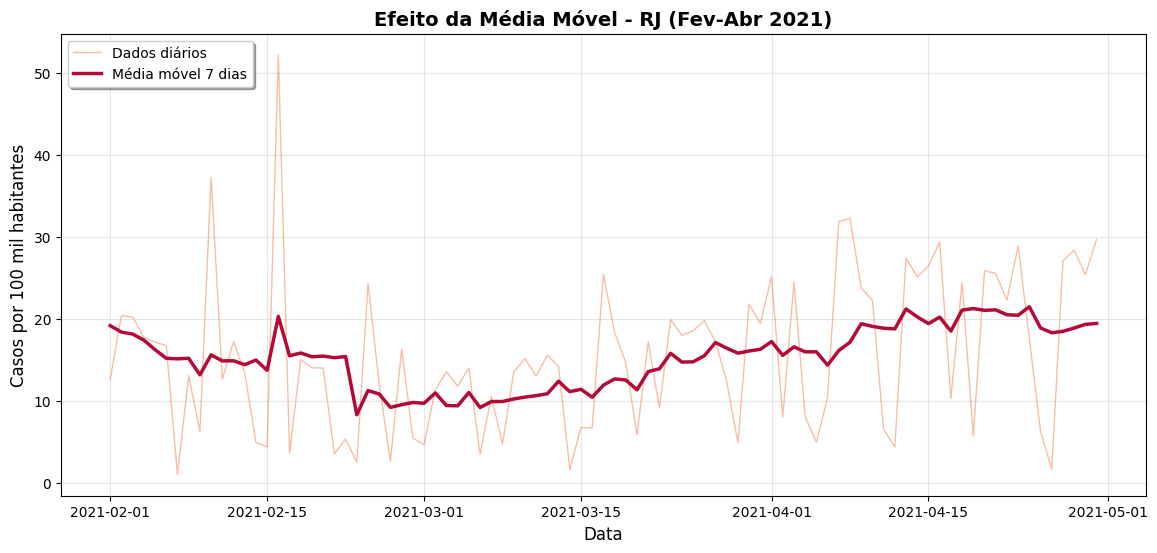

In [45]:
# Criando o gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Dados diários (com transparência)
ax.plot(dados_demo["date"], dados_demo["casos_100k"], 
        label="Dados diários", color="#F15A22", alpha=0.4, linewidth=1)

# Média móvel (linha sólida)
ax.plot(dados_demo["date"], dados_demo["mm7_casos_100k"], 
        label="Média móvel 7 dias", color="#B50938", linewidth=2.5)

ax.set_title(f"Efeito da Média Móvel - {uf_demo} (Fev-Abr 2021)", 
             fontsize=14, fontweight='bold')
ax.set_xlabel("Data", fontsize=12)
ax.set_ylabel("Casos por 100 mil habitantes", fontsize=12)
ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
#siborn cria melhor o gráfico
#aalter gráficos interativos

In [39]:
# Anotação explicativa
ax.annotate('Oscilações diárias\n(ruído)', 
            xy=(dados_demo.iloc[20]['date'], dados_demo.iloc[20]['casos_100k']),
            xytext=(dados_demo.iloc[20]['date'], dados_demo.iloc[20]['casos_100k'] + 20),
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            fontsize=10, color='gray')

ax.annotate('Tendência clara\n(média móvel)', 
            xy=(dados_demo.iloc[40]['date'], dados_demo.iloc[40]['mm7_casos_100k']),
            xytext=(dados_demo.iloc[40]['date'], dados_demo.iloc[40]['mm7_casos_100k'] - 25),
            arrowprops=dict(arrowstyle='->', color='#B50938', alpha=0.7),
            fontsize=10, color='#B50938')

plt.tight_layout()
plt.show()

print("\n💡 Veja como a média móvel revela a tendência real!")

<Figure size 640x480 with 0 Axes>


💡 Veja como a média móvel revela a tendência real!


### Etapa 6: Visualizações Avançadas

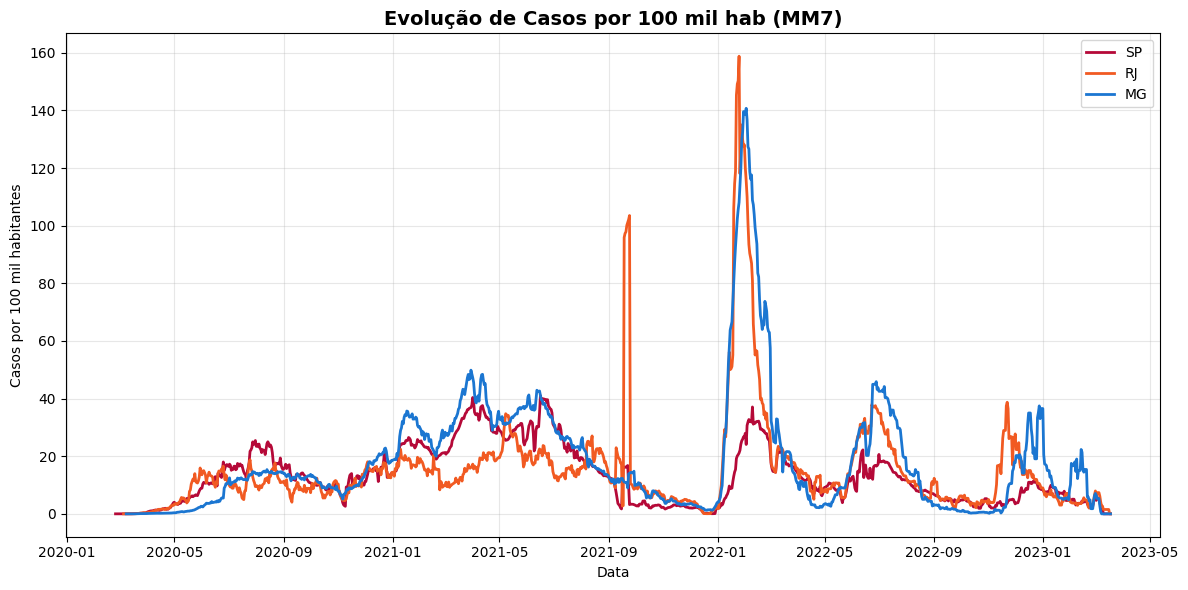

In [46]:
# Comparando 3 estados
estados = ["SP", "RJ", "MG"]
cores = ["#B50938", "#F15A22", "#1b76d1"]  # Cores Insper + azul

fig, ax = plt.subplots(figsize=(12, 6))
for estado, cor in zip(estados, cores):
    dados = df[df["uf"] == estado]
    ax.plot(dados["date"], dados["mm7_casos_100k"], 
            label=estado, color=cor, linewidth=2)

ax.set_title("Evolução de Casos por 100 mil hab (MM7)", fontsize=14, fontweight='bold')
ax.set_xlabel("Data")
ax.set_ylabel("Casos por 100 mil habitantes")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()